# Particle Identification (PID) with a (deep) Neural Network

This notebook highlights the usae of a neural network for particle identification on a synthetic data set. In a first step, we are going to create a synthetic data set, representing a very simplified detector

## Creating a synthetic Data Set 

The synthetic data set consists of two particles (e.g. electron and pion) that are measured with a hypothetical detctor setup. Each particle is characterized by three variables. 
Variable 1 refers to the particles momentum, variable 2 and 3 repsresent the response from sub-detectors (e.g. calorimeter, threshold counter,..). We are defining a function below that creates all these three variables. 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

# Define functions that return variables:

# Variable 1:
def get_var1(nevs,range=(0.5,10.0)):
    return np.random.uniform(low=range[0],high=range[1],size=(nevs,))

# Variable 2: 
# For species 0: var2 ~ var1
# For species 1: var2 ~ 1/var1
def get_var2(var1,scale,offset,species):
    if species == 0:
        return scale * var1 + offset
    
    if species == 1:
        return scale / var1 + offset
    
# Variable 3: var3 ~ sigmoid(var1)
def get_var3(var1,scale,offset):
    arg = scale*(var1 + offset)
    return 1.0/(1.0 + np.exp(-arg)) 

# Apply resolution effects, based on variable 3:
# Resolution is applied the following way:
# x_smeared = x_clean * N(1.0,rel_smear) + N(0,abs_smear)
# where N(,) is a normal distribution
# rel_smear is defined by: rel_smear ~ var3
# abs_smear is a constant 
def get_resolution(var,var3,res_val,abs_val):
    relative_smearing = np.random.normal(loc=np.ones_like(var3),scale=res_val*var3)
    return var * relative_smearing + np.random.normal(loc=0.0,scale=abs_val,size=var.shape)

# Now that we have all functions in place, we may define a helfper function that create the nice data for us:
def create_synthetic_data(
    n_events_0,
    ratio_0_1,
    max_rel_res_1_0=0.1,
    max_rel_res_2_0=0.2,
    abs_res_1_0=0.5,
    abs_res_2_0=0.4,
    max_rel_res_1_1=0.1, 
    max_rel_res_2_1=0.3,
    abs_res_1_1=0.5,
    abs_res_2_1=0.5,
):
   
   # The number of events for species 1 is given by the number of events for species 0 and the corresponding abundance ratio:
   n_events_1 = int(n_events_0*ratio_0_1)
   # Resolution settings for the individual variables and species:

   # Get three variables for species 0:
   var1_0 = get_var1(n_events_0)
   var2_0 = get_var2(var1_0,2.0,1.0,0)
   var3_0 = get_var3(var1_0,1.0,-5.0)

   # Apply resolution effects:
   var1_0 = get_resolution(var1_0,var3_0,max_rel_res_1_0,abs_res_1_0)
   var2_0 = get_resolution(var2_0,var3_0,max_rel_res_2_0,abs_res_2_0)

   # Get three variables for species 1:
   var1_1 = get_var1(n_events_1)
   var2_1 = get_var2(var1_1,0.92,0.05,1)
   var3_1 = get_var3(var1_1,1.0,-5.0)

   # Apply resolution effects: 
   var1_1 = get_resolution(var1_1,var3_1,max_rel_res_1_1,abs_res_1_1)
   var2_1 = get_resolution(var2_1,var3_1,max_rel_res_2_1,abs_res_2_1)
      
   # Combine all three variables to events that contain both species:
   var1_all = np.concatenate([var1_0,var1_1],axis=0)
   var2_all = np.concatenate([var2_0,var2_1],axis=0)
   var3_all = np.concatenate([var3_0,var3_1],axis=0)

   # Get labels which we will use later for classification:
   labels_0 = np.zeros_like(var1_0)
   labels_1 = np.ones_like(var1_1)
   labels_all = np.concatenate([labels_0,labels_1],axis=0)

   # Mix it all together, so that we have some randomness:
   var1_all, var2_all, var3_all, labels_all = shuffle(var1_all, var2_all, var3_all, labels_all)

   data = {
    'var1':var1_all,
    'var2':var2_all,
    'var3':var3_all,
    'label':labels_all
   }

   return pd.DataFrame(data)


/var/folders/tm/fdv69q4j3_7cxyrhyqwyxy8w0000gn/T/ipykernel_96755/3024430202.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Use the above function to generate our synthetic data:
print("Create synthetic data...")

synthetic_data = create_synthetic_data(200000,0.1)
print(synthetic_data.describe())

print("...done!")
print("  ")

Create synthetic data...
                var1           var2           var3          label
count  220000.000000  220000.000000  220000.000000  220000.000000
mean        5.239184       1.927102       0.524394       0.090909
std         2.837602       1.469736       0.382286       0.287480
min        -1.073526      -0.816556       0.010987       0.000000
25%         2.861219       1.177795       0.105665       0.000000
50%         5.172783       1.567462       0.557797       0.000000
75%         7.526184       2.090794       0.931880       0.000000
max        14.032284      18.021523       0.993307       1.000000
...done!
  


## Visualize Toy Data Set

Before starting any funny business, we are going to plot the toy data set, just to get a feeling about what we are dealing with.

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rcParams.update({'font.size':20})

# First, we define a plotting function that we can reuse multiple times:
def visualize_data(
        var1,
        var2,
        var3,
        labels,
        plot_title,
        min_var1=0.0,
        max_var1=15.0,
        min_var2=0.0,
        max_var2=15.0,
        min_var3=0.0,
        max_var3=1.0
    ):

    # Get the variables for the individual species:
    var1_0 = var1[labels==0.0]
    var2_0 = var2[labels==0.0]
    var3_0 = var3[labels==0.0]

    var1_1 = var1[labels==1.0]
    var2_1 = var2[labels==1.0]
    var3_1 = var3[labels==1.0]


    fig,ax = plt.subplots(3,3,figsize=(12,10))
    fig.subplots_adjust(wspace=0.5,hspace=0.5)
    fig.suptitle(plot_title)

    ax[0,0].hist2d(var1_0,var2_0,bins=100,norm=LogNorm(),range=[[min_var1,max_var1],[min_var2,max_var2]])
    ax[0,0].set_xlabel('Variable 1')
    ax[0,0].set_ylabel('Variable 2')
    ax[0,0].grid(True)
    ax[0,0].set_title('Particle 0')

    ax[0,1].hist2d(var1_1,var2_1,bins=100,norm=LogNorm(),range=[[min_var1,max_var1],[min_var2,max_var2]])  
    ax[0,1].set_xlabel('Variable 1')
    ax[0,1].set_ylabel('Variable 2')
    ax[0,1].grid(True)
    ax[0,1].set_title('Particle 1')

    ax[0,2].hist2d(var1,var2,bins=100,norm=LogNorm(),range=[[min_var1,max_var1],[min_var2,max_var2]])
    ax[0,2].set_xlabel('Variable 1')
    ax[0,2].set_ylabel('Variable 2')
    ax[0,2].set_title('Particle 0 & 1')
    ax[0,2].grid(True)

    ax[1,0].hist2d(var1_0,var3_0,bins=100,norm=LogNorm(),range=[[min_var1,max_var1],[min_var3,max_var3]])
    ax[1,0].set_xlabel('Variable 1') 
    ax[1,0].set_ylabel('Variable 3')
    ax[1,0].grid(True)

    ax[1,1].hist2d(var1_1,var3_1,bins=100,norm=LogNorm(),range=[[min_var1,max_var1],[min_var3,max_var3]])
    ax[1,1].set_xlabel('Variable 1')
    ax[1,1].set_ylabel('Variable 3')
    ax[1,1].grid(True)

    ax[1,2].hist2d(var1,var3,bins=100,norm=LogNorm(),range=[[min_var1,max_var1],[min_var3,max_var3]])
    ax[1,2].set_xlabel('Variable 1')
    ax[1,2].set_ylabel('Variable 3')
    ax[1,2].grid(True)

    ax[2,0].hist2d(var3_0,var2_0,bins=100,norm=LogNorm(),range=[[min_var3,max_var3],[min_var2,max_var2]])
    ax[2,0].set_xlabel('Variable 3')
    ax[2,0].set_ylabel('Variable 2')
    ax[2,0].grid(True)

    ax[2,1].hist2d(var3_1,var2_1,bins=100,norm=LogNorm(),range=[[min_var3,max_var3],[min_var2,max_var2]])
    ax[2,1].set_xlabel('Variable 3')
    ax[2,1].set_ylabel('Variable 2')
    ax[2,1].grid(True)

    ax[2,2].hist2d(var3,var2,bins=100,norm=LogNorm(),range=[[min_var3,max_var3],[min_var2,max_var2]])
    ax[2,2].set_xlabel('Variable 3')
    ax[2,2].set_ylabel('Variable 2')
    ax[2,2].grid(True)
 

Visualize synthetic data...
...done!
 


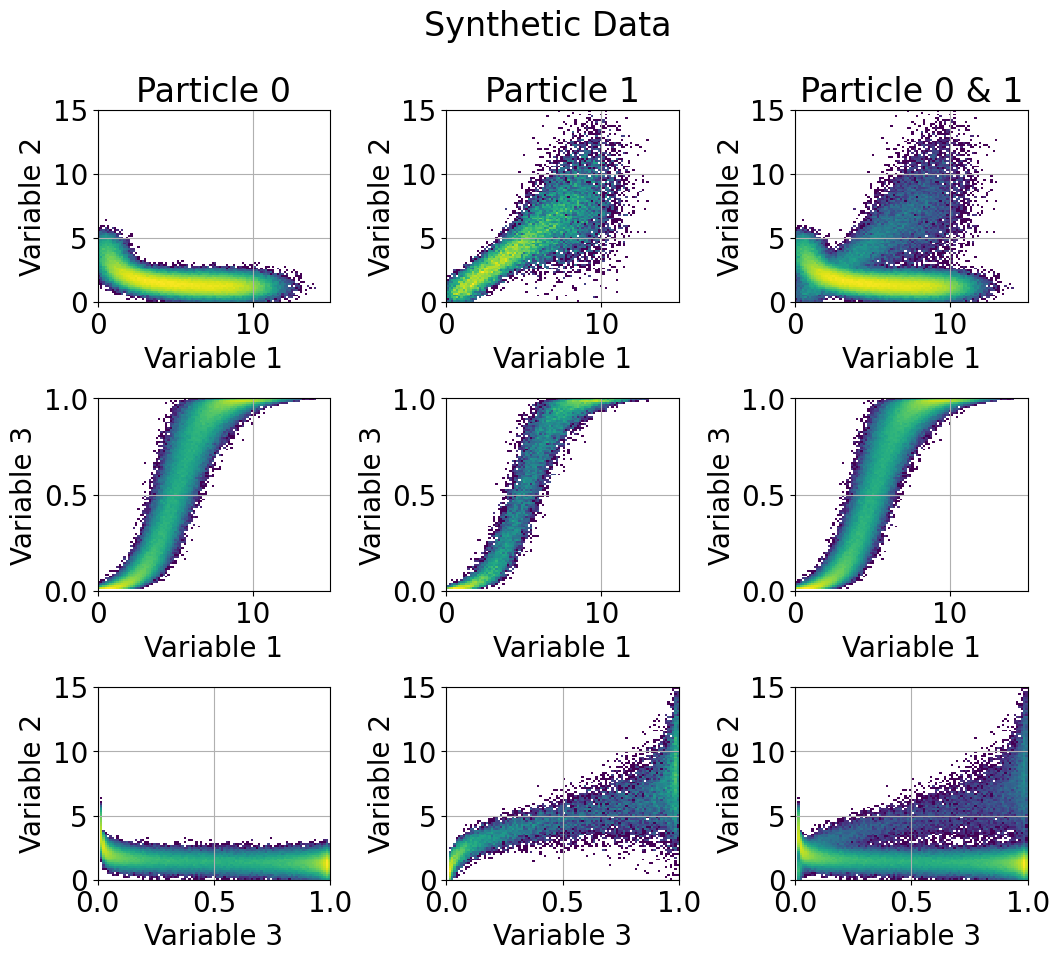

In [4]:
# Visualuze the synthetic data:
print("Visualize synthetic data...")

visualize_data(synthetic_data.var1,synthetic_data.var2,synthetic_data.var3,synthetic_data.label,"Synthetic Data")

print("...done!")
print(" ")

## Run a cut based Analysis as a Benchmark

Whenever working with Machine (Deep) Learning, it is always advisable to have benchmark analysis. Here, we will use a simple set of cuts which we abstract from a visual inspection of the top plot.

In [5]:
# Define cut based analysis:
def run_cut_based_analysis(var1,var2,cut):
    # Linear cut on the var1 vs. var2:
    return np.where(var2>=cut*var1,1.0,0.0)


Run cut based analysis...
                var1           var2           var3          label  \
count  220000.000000  220000.000000  220000.000000  220000.000000   
mean        5.239184       1.927102       0.524394       0.090909   
std         2.837602       1.469736       0.382286       0.287480   
min        -1.073526      -0.816556       0.010987       0.000000   
25%         2.861219       1.177795       0.105665       0.000000   
50%         5.172783       1.567462       0.557797       0.000000   
75%         7.526184       2.090794       0.931880       0.000000   
max        14.032284      18.021523       0.993307       1.000000   

       label_cut_based  
count    220000.000000  
mean          0.354036  
std           0.478221  
min           0.000000  
25%           0.000000  
50%           0.000000  
75%           1.000000  
max           1.000000  
...done! Obtained accuracy 82.48100000000001 %
 


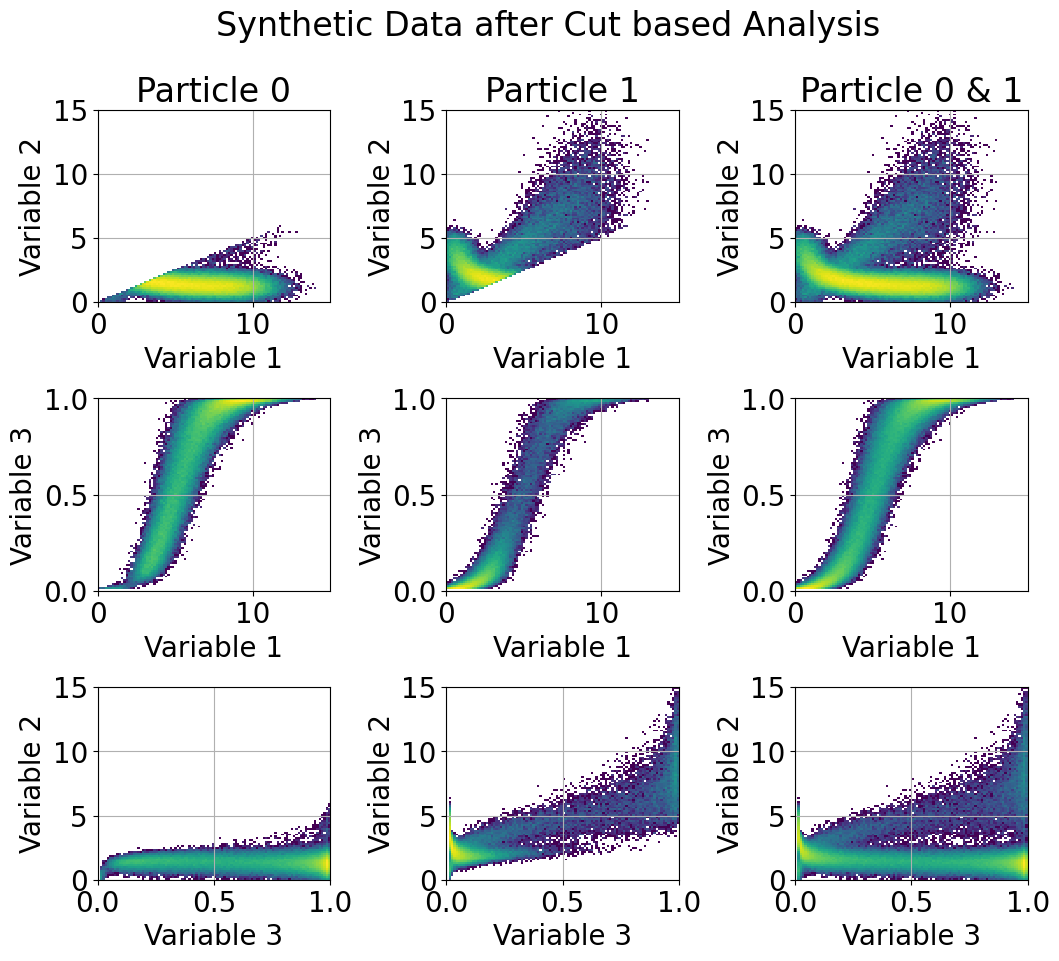

In [6]:
from sklearn.metrics import balanced_accuracy_score

# Run the cut based analysis:
print("Run cut based analysis...")

labels_cut_based = run_cut_based_analysis(synthetic_data.var1,synthetic_data.var2,0.5)
# Compute the accuracy, i.e. how precise is our cut based anaysis:
accuracy_cut_based = balanced_accuracy_score(synthetic_data.label,labels_cut_based)
# Plot the results after applying the cut:
visualize_data(synthetic_data.var1,synthetic_data.var2,synthetic_data.var3,labels_cut_based,"Synthetic Data after Cut based Analysis")
# Add the label from the cut based analysis to our data frame, just so that we have it:
synthetic_data['label_cut_based'] = labels_cut_based
print(synthetic_data.describe())

print(f"...done! Obtained accuracy {accuracy_cut_based*100} %")
print(" ")



## Run Analysis with a (deep) Neural Network

After running the analysis in a conventional way, we move over to a machine learning based one. 

### Step 1: Prepare Data for Analysis

The ranges of the three variables differ, i.e. variable 1 and 2 range from 0 to 10, whereas 3 ranges from 0 to 1. This may cause trouble for the neural network, as it might try to adjust its weights in order to compensate for this difference. We therefore want to scale the data such that all variable ranges are equal. 

Create scaled synthetic data set...
                var1           var2           var3          label
count  220000.000000  220000.000000  220000.000000  220000.000000
mean        0.417899       0.145644       0.522647       0.090909
std         0.187848       0.078019       0.389167       0.287480
min         0.000000       0.000000       0.000000       0.000000
25%         0.260479       0.105868       0.096382       0.000000
50%         0.413504       0.126553       0.556651       0.000000
75%         0.569298       0.154334       0.937468       0.000000
max         1.000000       1.000000       1.000000       1.000000
..done!
 


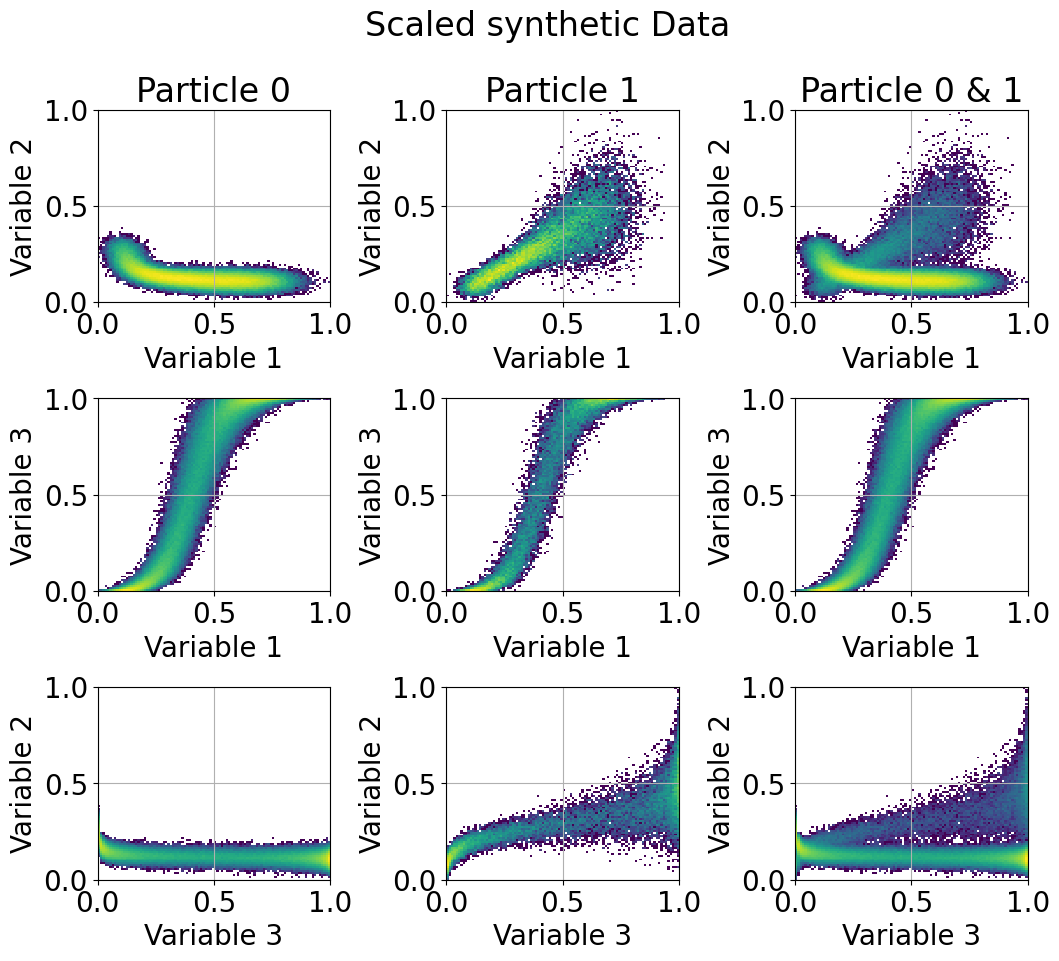

In [7]:
from sklearn.preprocessing import MinMaxScaler

print("Create scaled synthetic data set...")

# Scale the data such that it is scaled between 0 and 1:
scaler = MinMaxScaler((0.0,1.0))
scaled_data = scaler.fit_transform(synthetic_data[['var1','var2','var3']])
# The resulting data format is a numpy array. For convenience, we are going to translate this to Pandas data frame, just so that it is consistent with the previous data format
scaled_synthetic_data = pd.DataFrame(scaled_data,columns=['var1','var2','var3'])
scaled_synthetic_data['label'] = synthetic_data.label
print(scaled_synthetic_data.describe())
# Visualize the scaled data:
visualize_data(
    scaled_synthetic_data.var1,
    scaled_synthetic_data.var2,
    scaled_synthetic_data.var3,
    scaled_synthetic_data.label,
    "Scaled synthetic Data",
    min_var1=0.0,
    max_var1=1.0,
    min_var2=0.0,
    max_var2=1.0,
    min_var3=0.0,
    max_var3=1.0    
)

print("..done!")
print(" ")



## Step 2: Setup the Neural Network

This step consists of two parts, defining the network itself, followed by the optimizer which runs the training and weight updates for us. 

In [8]:
import tensorflow as tf

# Set up the network:
def setup_neural_network(n_inputs,n_hidden_layers,n_neurons,model_name,hidden_activations='leaky_relu',weight_inits='glorot_normal',bias_inits='zeros',dropouts=0.0):
    # Initialize the model and define the number of inputs:
    model = tf.keras.Sequential(name=model_name)
    model.add(tf.keras.Input(shape=(n_inputs,)))
    
    act_fn = hidden_activations.lower()
    if hidden_activations.lower() == 'leaky_relu':
        act_fn = tf.keras.layers.LeakyReLU(0.2)

    # Add hidden layers:
    for _ in range(n_hidden_layers):
        model.add(
            tf.keras.layers.Dense(
                units=n_neurons,
                activation=act_fn,
                kernel_initializer=weight_inits,
                bias_initializer=bias_inits
            )
        )
        # Add dropouts, if required:
        if dropouts > 0.0:
            model.add(tf.keras.layers.Dropout(dropouts))

    # Add the final (output) layers:
    model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
    return model

# Compile the model, i.e. define the optimizer and loss function and any additional metrics:
def compile_model(model,learning_rate,loss_fn='binary_crossentropy',metrics=['accuracy'],optimizer='adam'):
    optim = tf.keras.optimizers.RMSprop(learning_rate)
    if optimizer.lower() == 'adam':
        optim = tf.keras.optimizers.Adam(learning_rate)
    if optimizer.lower() == 'sgd':
        optim = tf.keras.optimizers.SGD(learning_rate)
    
    model.compile(optimizer=optim,loss=loss_fn,metrics=metrics)
    print(model.summary())


2025-01-21 17:47:31.279939: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# Build our model:
print("Build neural network v0...")

neural_network_v0 = setup_neural_network(3,3,10,'neural_network_v0')
compile_model(neural_network_v0,1e-3)

print("...done!")
print(" ")

Build neural network v0...


2025-01-21 17:47:37.423092: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-21 17:47:37.423155: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "neural_network_v0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                40        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 271
Trainable params: 271
Non-trainable params: 0
_________________________________________________________________
None
...done!
 


### Step 3: Train the Neural Network

Now that we have our network and its optimizer, we may no move to the exciting part and actually train both models. 


In [ ]:
# Define important training parameters:
n_epochs = 30
batch_size = 1024
validation_split = 0.25

# Run the training:
training_results_v0 = neural_network_v0.fit(
    x=scaled_synthetic_data[['var1','var2','var3']],
    y=scaled_synthetic_data.label,
    batch_size=batch_size,
    epochs=n_epochs,
    validation_split=validation_split,
    class_weight={0:1.0,1:1.0}
)

tf.keras.backend.clear_session()

Epoch 1/20


2025-01-21 17:47:42.853521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-21 17:47:42.927116: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


162/162 [==============================] - ETA: 0s - loss: 0.4182 - accuracy: 0.8996

2025-01-21 17:47:45.574246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


162/162 [==============================] - 4s 16ms/step - loss: 0.4182 - accuracy: 0.8996 - val_loss: 0.3066 - val_accuracy: 0.9099
Epoch 2/20
162/162 [==============================] - 2s 12ms/step - loss: 0.2417 - accuracy: 0.9181 - val_loss: 0.1692 - val_accuracy: 0.9467
Epoch 3/20
162/162 [==============================] - 2s 12ms/step - loss: 0.1468 - accuracy: 0.9556 - val_loss: 0.1293 - val_accuracy: 0.9620
Epoch 4/20
162/162 [==============================] - 2s 12ms/step - loss: 0.1222 - accuracy: 0.9640 - val_loss: 0.1126 - val_accuracy: 0.9678
Epoch 5/20
162/162 [==============================] - 2s 12ms/step - loss: 0.1098 - accuracy: 0.9685 - val_loss: 0.1037 - val_accuracy: 0.9708
Epoch 6/20
162/162 [==============================] - 2s 12ms/step - loss: 0.1028 - accuracy: 0.9711 - val_loss: 0.0983 - val_accuracy: 0.9723
Epoch 7/20
162/162 [==============================] - 2s 12ms/step - loss: 0.0980 - accuracy: 0.9723 - val_loss: 0.0943 - val_accuracy: 0.9737
Epoch 8/20

### Step 4: Plot the learning Curves - Very Important !

The training of any machine learning model is meaningless, if no diagnostic plots are provided. There are a few "standard" diagnostic plots that you should have at hand at any time. 

In [11]:
# Define a function to plot the learning curves:
def plot_learning_curves(training_history):
    fig,ax = plt.subplots(1,2,figsize=(12,8))
    fig.subplots_adjust(wspace=0.5)

    ax[0].plot(training_history.history['loss'],linewidth=3.0,label='Training')
    ax[0].plot(training_history.history['val_loss'],linewidth=3.0,label='Validation')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].grid(True)
    ax[0].legend(fontsize=15)

    ax[1].plot(training_history.history['accuracy'],linewidth=3.0,label='Training')
    ax[1].plot(training_history.history['val_accuracy'],linewidth=3.0,label='Validation')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].grid(True)
    ax[1].legend(fontsize=15)
    

Plot learning curves for network v0...
...done!
 


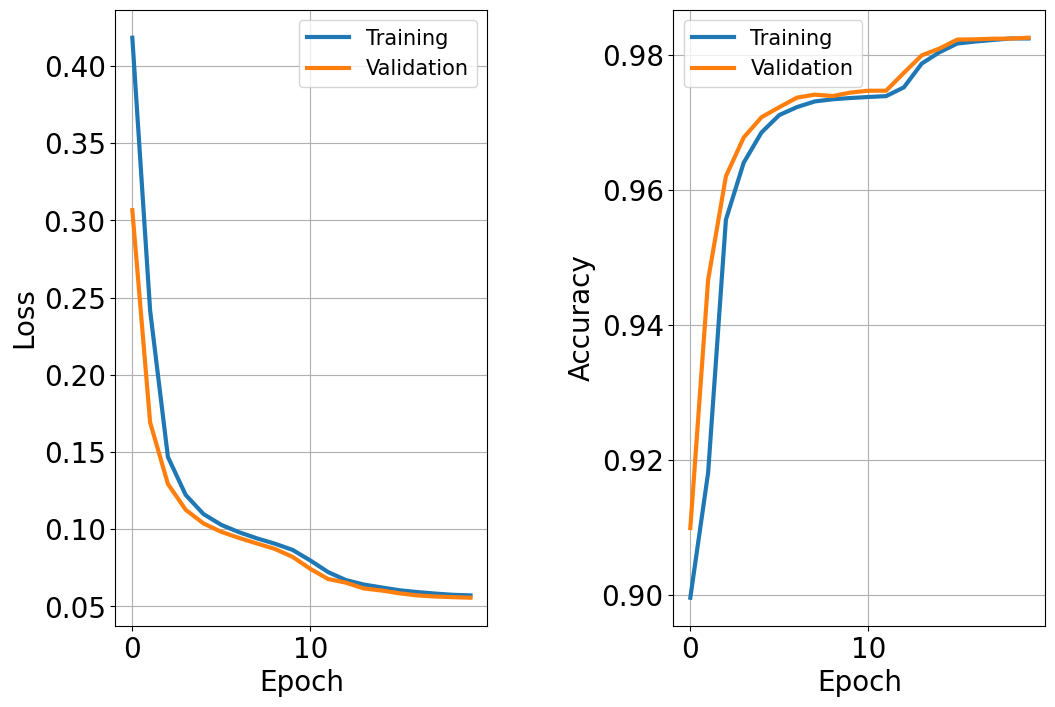

In [12]:
# Plot learning curves:
print("Plot learning curves for network v0...")

plot_learning_curves(training_results_v0)

print("...done!")
print(" ")

### Step 5: Performance Evaluation 

This last step is crucial as it determines what will happen next, i.e. deploy the model or retrain it... In the following, we are going to produce a set of diagnostic plots that are vital for the evaluation of our freshly trained network. 

#### 5.1) Get and Visualize the Network Response

First, we would like to know what the neural network tells us, when we feed our data into it. The response plots are the foundation of the performance evaluation, as they are the foundation of all other performance metrics. 

In [13]:
print("Get response from neural network v0 on synthetic data...")

network_predictions = neural_network_v0.predict(scaled_synthetic_data[['var1','var2','var3']])
# Add predictions to the data frame, just for book keeping:
scaled_synthetic_data['network_response'] = network_predictions
print(scaled_synthetic_data.describe())

print("...done!")
print(" ")


Get response from neural network v0 on synthetic data...
  37/6875 [..............................] - ETA: 19s 

2025-01-21 17:48:37.626623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6875/6875 [==============================] - 16s 2ms/step
                var1           var2           var3          label  \
count  220000.000000  220000.000000  220000.000000  220000.000000   
mean        0.417899       0.145644       0.522647       0.090909   
std         0.187848       0.078019       0.389167       0.287480   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.260479       0.105868       0.096382       0.000000   
50%         0.413504       0.126553       0.556651       0.000000   
75%         0.569298       0.154334       0.937468       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

       network_response  
count      2.200000e+05  
mean       8.759371e-02  
std        2.552693e-01  
min        3.760869e-11  
25%        1.337886e-05  
50%        4.086389e-04  
75%        1.595002e-02  
max        1.000000e+00  
...done!
 


In [14]:
# Define function to visualize the predictions:
def visualize_network_response(pred_labels,true_labels,threshold=None,threshold_name='Threshold',use_log=True):
    fig,ax = plt.subplots(figsize=(8,8))

    n, _ ,_ = ax.hist(pred_labels,100,histtype='step',color='k',linewidth=3.0,label='All',log=use_log)
    ax.hist(pred_labels[true_labels==1.0],100,color='g',alpha=0.5,label='Species 1')
    ax.hist(pred_labels[true_labels==0.0],100,color='r',alpha=0.5,label='Species 0')
    
    if threshold is not None:
        ax.plot([threshold,threshold],[0.0,np.max(n)],'k--',linewidth=3.0,label=threshold_name)

    ax.set_xlabel('Response Neural Network v0')
    ax.set_ylabel('Entries [a.u.]')
    ax.grid(True)
    ax.legend(fontsize=15)


Visualize response from neural network v0...
...done!
 


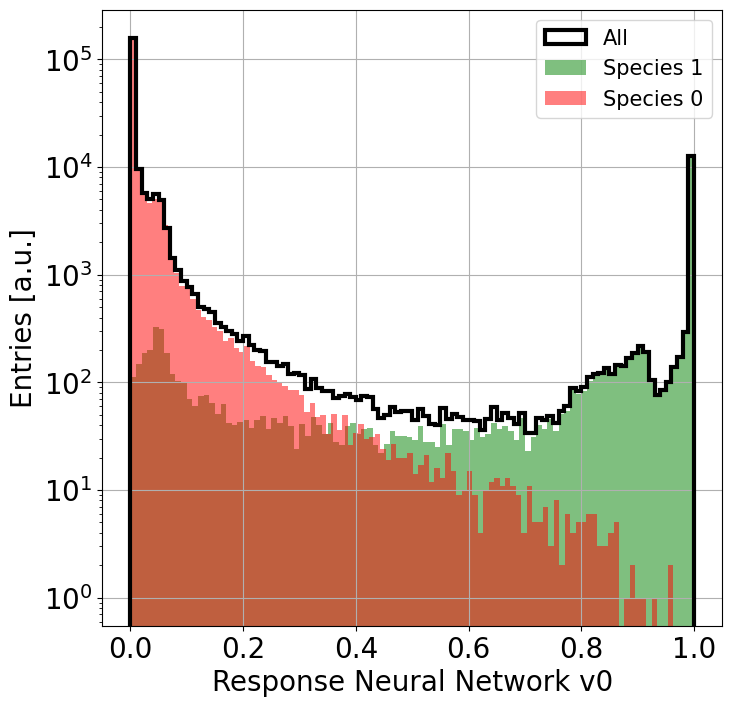

In [15]:
print("Visualize response from neural network v0...")

visualize_network_response(scaled_synthetic_data.network_response,scaled_synthetic_data.label)

print("...done!")
print(" ")

#### 5.2) ROC-Curve

Now that we have the response plots, we may ask ourselves where to place a cut on the response. An answer to that is given by the ROC-curve.


In [16]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(pred_labels,true_labels):
    fpr, tpr, thresholds = roc_curve(true_labels,pred_labels)
    auc_score = round(auc(fpr,tpr),2)

    # Run a quick threshold scan:
    obj = fpr**2 + (1.0-tpr)**2
    i_best = np.argmin(obj)
    tpr_best = tpr[i_best]
    fpr_best = fpr[i_best]

    fig,ax = plt.subplots(figsize=(8,8))

    ax.plot(fpr,tpr,linewidth=3.0,label=f'network v0, AUC={auc_score}')
    ax.plot([0.0,1.0],[0.0,1.0],linewidth=3.0,label='Random Guess')
    ax.plot([fpr_best,fpr_best],[0.0,tpr_best],'k--',linewidth=3.0,label='At threshold')
    ax.plot([0.0,fpr_best],[tpr_best,tpr_best],'k--',linewidth=3.0)
    ax.set_xlabel('False positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.grid(True)
    ax.legend(fontsize=15)

    return thresholds[i_best]

Plot ROC-curve...
..done!
 


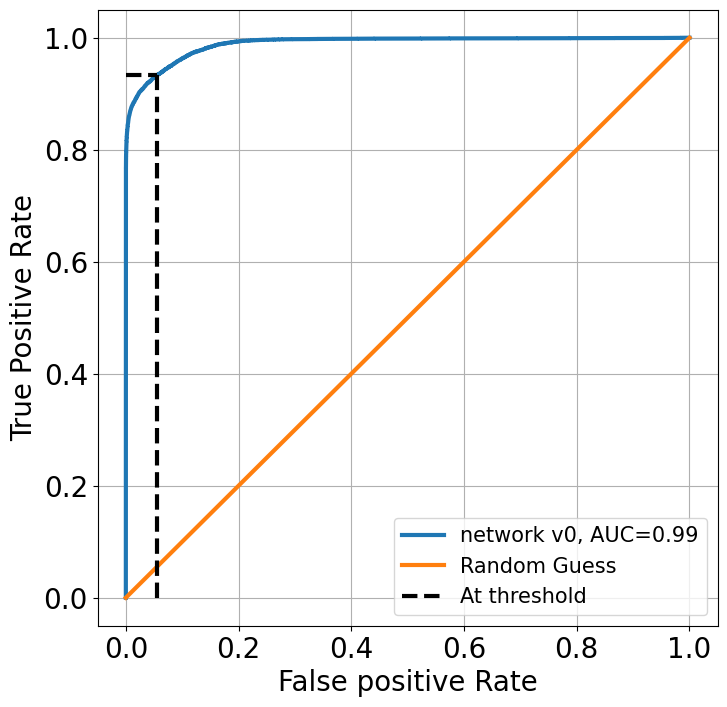

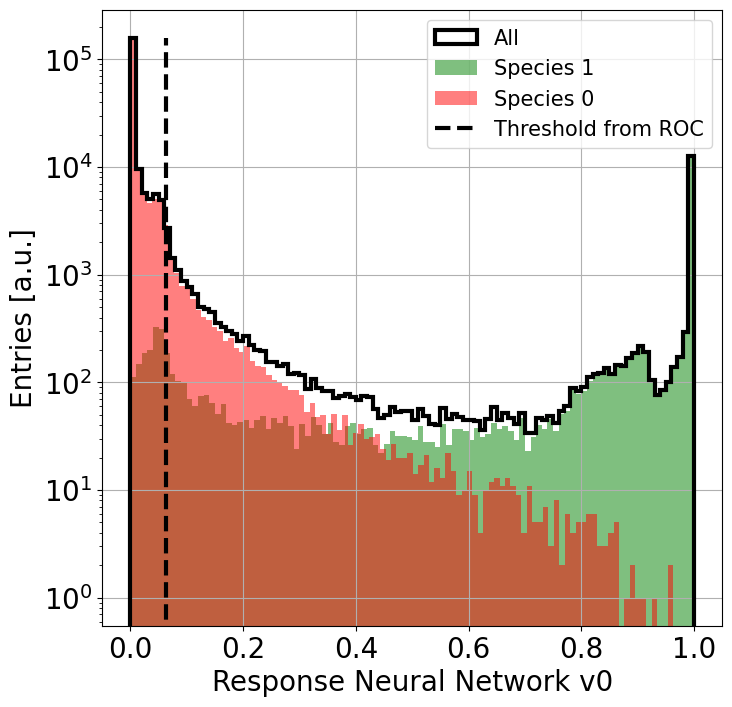

In [17]:
# Plot ROC-Curve and proper threshold
print("Plot ROC-curve...")

suggested_threshold = plot_roc_curve(scaled_synthetic_data.network_response,scaled_synthetic_data.label)
visualize_network_response(scaled_synthetic_data.network_response,scaled_synthetic_data.label,suggested_threshold,'Threshold from ROC')

print("..done!")
print(" ")

#### 5.3) Confusion Matrix

Once we have the optimum threshold, we can now compute important metrics like the confusion matrix. But first, we need to apply the threshold to our network.

In [18]:
print("Apply threshold to network...")

predicted_labels = np.where(scaled_synthetic_data.network_response >= suggested_threshold,1.0,0.0)
# Add new labels to dataframe:
scaled_synthetic_data['pred_label'] = predicted_labels
print(scaled_synthetic_data.describe())

print("..done!")
print(" ")

Apply threshold to network...
                var1           var2           var3          label  \
count  220000.000000  220000.000000  220000.000000  220000.000000   
mean        0.417899       0.145644       0.522647       0.090909   
std         0.187848       0.078019       0.389167       0.287480   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.260479       0.105868       0.096382       0.000000   
50%         0.413504       0.126553       0.556651       0.000000   
75%         0.569298       0.154334       0.937468       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

       network_response     pred_label  
count      2.200000e+05  220000.000000  
mean       8.759371e-02       0.134691  
std        2.552693e-01       0.341394  
min        3.760869e-11       0.000000  
25%        1.337886e-05       0.000000  
50%        4.086389e-04       0.000000  
75%        1.595002e-02       0.000000  
max        1.000000e

Text(0.5, 0.98, 'CM Cut')

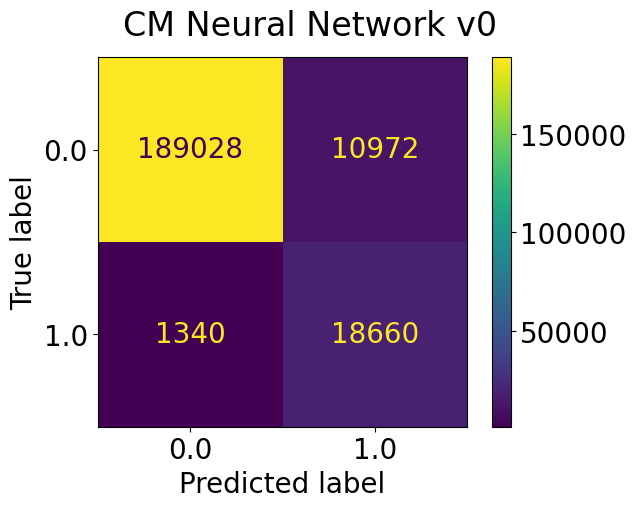

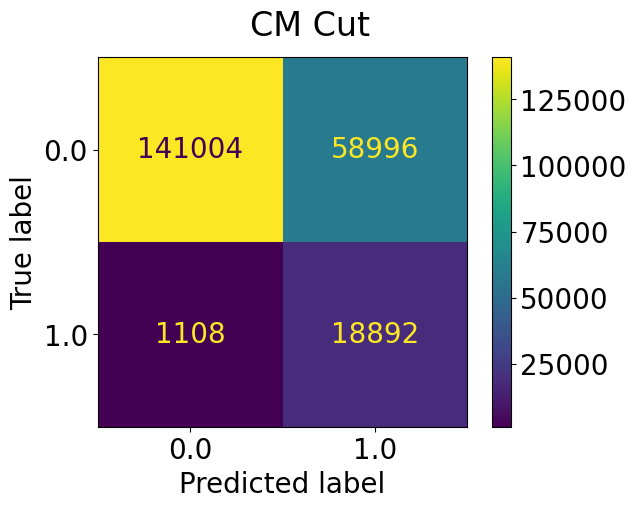

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(scaled_synthetic_data.label,scaled_synthetic_data.pred_label,labels=[0.0,1.0])
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0.0,1.0]).plot()
disp_cm.figure_.suptitle('CM Neural Network v0')

# For reference, we also plot the confusion matrix for the cut based analysis:
cm_cut = confusion_matrix(synthetic_data.label,labels_cut_based,labels=[0.0,1.0])
disp_cm_cut = ConfusionMatrixDisplay(confusion_matrix=cm_cut,display_labels=[0.0,1.0]).plot()
disp_cm_cut.figure_.suptitle('CM Cut')

#### 5.4) Compute Accuracy and plot Data after Classification

Lastly, we may compute the accuracy and take a look at our synthetic data after classification.

Compute accuracy and plot data after classification...
Accuracy cut based analysis: 82.48100000000001&, 81.1342811939644%
...done!
 


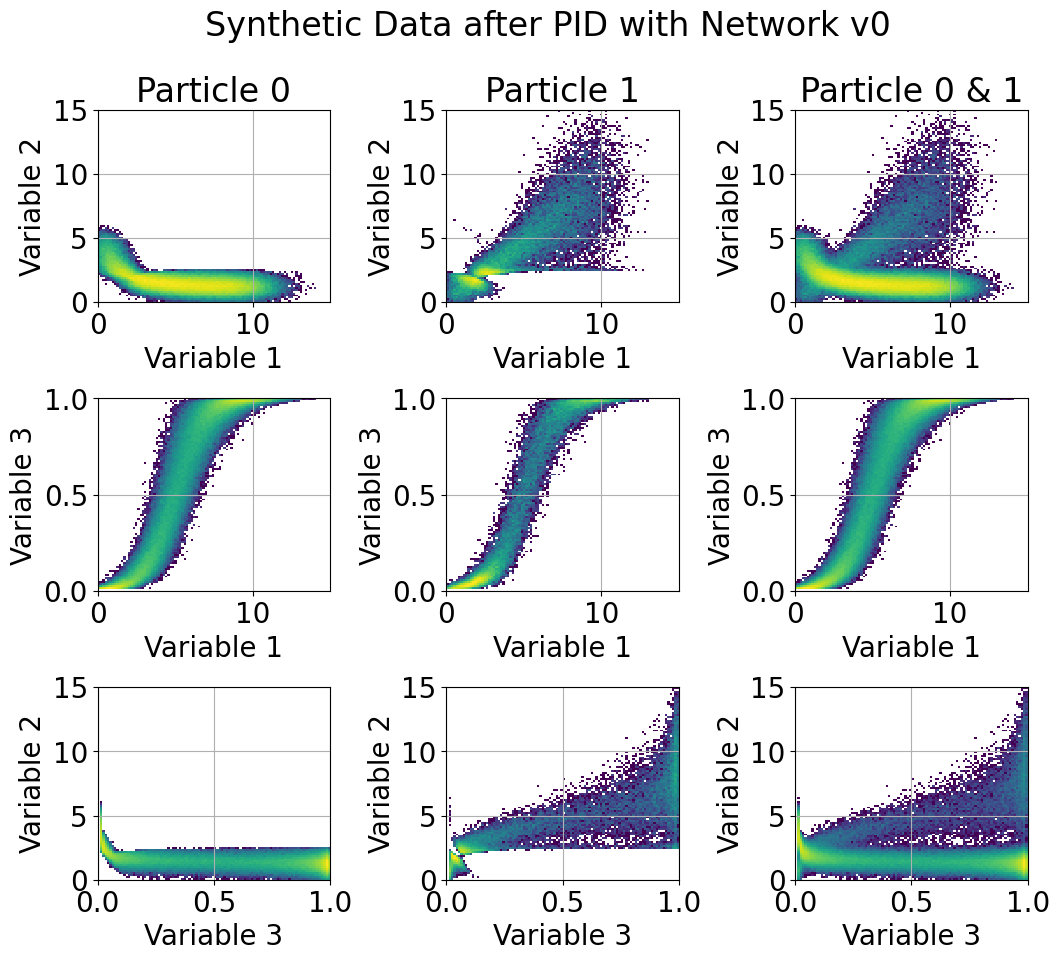

In [20]:
print("Compute accuracy and plot data after classification...")

accuracy_network_v0 = balanced_accuracy_score(scaled_synthetic_data.pred_label,scaled_synthetic_data.label)
visualize_data(synthetic_data.var1,synthetic_data.var2,synthetic_data.var3,scaled_synthetic_data.pred_label,'Synthetic Data after PID with Network v0')

print(f"Accuracy cut based analysis: {accuracy_cut_based*100}&, {accuracy_network_v0*100}%")

print("...done!")
print(" ")